In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Oil Density Estimation

## A Description of the Methods Used (Including Some Examples)

### Background:

The density of a substance is a fairly important piece of information to know in regards to oil spill response.  If an oil is released into a body of water, its relative density to that body of water will indicate whether the oil will float on top of the water surface, or whether it will gradually sink below the surface.

There are two general properties in an oil record that indicate its initial density.  Those are the oils **API** gravity, and its **measured density**.

An oil's API gravity is a measure of how heavy or light it is compared to water, as defined by the
**A**merican **P**etroleum **I**nstitute. As such it is essentially a different unit for the density of the oil at standard temperature (and pressure). If there is a measured density (at 15C) and an API in a given record, the values should match, or there is an error in the record.


**API** gravity is defined by the following formula:

$$
\begin{align}
\rho_{0_{oil}} &= \text{The initial oil density at } 15^\circ C \text{ and measured in } kg / m^3 \\
1000 &= \text{The initial density of fresh water measured in } kg / m^3 \\
API &= \frac{141.5 \cdot 1000}{\rho_{0_{oil}} } - 131.5 \\
\end{align}
$$

Conversely, the initial density of the oil can be calculated, if necessary, from the API value

$$
\begin{align}
\rho_{0_{oil}} &= \frac{141.5}{131.5 + API} \cdot 1000 \\
\end{align}
$$

### Some Examples

Ok, let's apply this to some examples using records in our oil library.

First we will import some things from our oil library that we will need.

In [2]:
from oil_library import get_oil, get_oil_props, _get_db_session
from oil_library.models import (Base, ImportedRecord, Oil,
                                Density, Toxicity, Category)
from oil_library.oil_props import OilProps

# The session object can be queried to get individual records using SQLAlchemy's quering mechanisms
# http://www.sqlalchemy.org/

session = _get_db_session()

/usr/local/anaconda-python3/envs/opendrift-cicese/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Now we can query for an oil that we are interested in.

#### Example 1:  Estimating Density 

For the first example we will use a reasonably heavy oil for which we have no measured density values. (i.e. only API)

In [3]:
oil_obj = (session.query(Oil)
           .filter(Oil.name == 'BOSCAN, OIL & GAS')
           .one())
print (oil_obj)

<Oil("BOSCAN, OIL & GAS")>


First, a little bit of background.  The records in the PyGnome oil library have been imported from a master copy of the NOAA oil library data, and the original values are stored in the 'imported' attribute of the oil object, so we can see the original imported data:

In [4]:
print (oil_obj.imported.densities)
print (oil_obj.imported.api)

[]
10.1


Here we can see that the original imported record contains no measured densities, but has a valid API value.<br>
And as discussed above, the density at $ 15^\circ C $ in $kg/m^3$ can be converted from the API as follows:

In [5]:
density_at_15c = 141.5 / (131.5 + 10.1) * 1000
print (density_at_15c)

999.2937853107345


So for this oil, we give it a single density at $ 15^\circ C $ since the imported record did not supply any.

In [6]:
print (oil_obj.densities)
print (oil_obj.api)

[<Density(999.2937853107345 kg/m^3 at 288.15K)>]
10.1


At this point it is worth mentioning that internally, we use temperatures that are measured in Kelvin.<br>
So $ 15^\circ C $ converted into Kelvin would be:

$$
\begin{align}
273.15 + 15^\circ C &= 288.15^\circ K
\end{align}
$$

#### Example 2:  Estimating API

Ok, now we will examine an oil that has no API, but does in fact have some measured densities.

In [7]:
oil_obj = (session.query(Oil)
           .filter(Oil.name == 'COOPER BASIN LIGHT NAPHTHA, SANTOS LTD')
           .one())
print (oil_obj)
print (oil_obj.imported.densities)
print (oil_obj.imported.api)

<Oil("COOPER BASIN LIGHT NAPHTHA, SANTOS LTD")>
[<Density(660.0 kg/m^3 at 288.0K)>]
None


Here we can see that the original imported record contains a single measured density, but has no API value.<br>
The API can be computed from the measured density.

In this case, the measured density is a 288.15K, which is $ 15^\circ C $, the standard tempuerature for API, so the conversion can be done directly.

There are records in the oil library in which the densities are measured at temperatures quite far from the standard $ 15^\circ C $ <br>

In this case, the density at $ 15^\circ C $ can be estimated from teh measured values using a standard expansion coefficient.

When interpolating a density value at a measured temperature to one at a desired temperature, we use the following formula(s):

$$
\begin{align}
k_{\rho T} &= 0.008 K^{-1} \cr
T_{ref} &= \text{our reference temperature} \cr
T_0 &= \text{our desired temperature} \cr
\rho_{ref} &= \rho_0 \cdot (1 - k_{\rho T} \cdot (T_{ref} - T_0)) \cr
&\text{thus...} \cr
\rho_0 &= {\rho_{ref} \over (1 - k_{\rho T} \cdot (T_{ref} - T_0))} \cr
\end{align}
$$

Let's apply this method to our reference density.

In [8]:
density_at_temp = 660.0 / (1 - 0.008 * (288.0 - 288.15))
print (density_at_temp)

659.208949260887


We now have the density at $ 15^\circ C $, which we will use to estimate the API value.<br>
And as it so happens, we have packaged this formula into a convenience function.

In [9]:
from oil_library.utilities.estimations import density_at_temp
rho = oil_obj.densities[0].kg_m_3
ref_temp = oil_obj.densities[0].ref_temp_k
print (rho, ref_temp)
density_at_15 = density_at_temp(rho, ref_temp, 288.15)
print (density_at_15)

660.0 288.0
659.9208095028597


In [10]:
api = (141.5 * 1000 / density_at_15) - 131.5
print (api)

# and the value in the processed record:
print (oil_obj.api)

82.91966666666664
82.91966666666664


...and as you can see, this is the API value that our oil object contains.

### Querying the database

The datbase can be queried to find records of interest.

a DB session was created above -- it can be accessed to find what is being looked for:

In [11]:
# all oils with "alaska" in the name
session.query(Oil).filter(Oil.name.like("%alaska%")).all()

[<Oil("ALASKA NORTH SLOPE")>,
 <Oil("ALASKA NORTH SLOPE, OIL & GAS")>,
 <Oil("ALASKA NORTH SLOPE (MIDDLE PIPELINE, 1996)")>,
 <Oil("ALASKA NORTH SLOPE (NORTHERN PIPELINE, 1996)")>,
 <Oil("ALASKA NORTH SLOPE (SOUTHERN PIPELINE, 1996)")>,
 <Oil("ALASKA NORTH SLOPE (MIDDLE PIPELINE, 1997)")>,
 <Oil("ALASKA NORTH SLOPE (NORTHERN PIPELINE, 1997)")>,
 <Oil("FUEL OIL NO.1 (JET B, ALASKA)")>,
 <Oil("ALASKA NORTH SLOPE-PUMP STATION #9, BP")>,
 <Oil("ALASKA NORTH SLOPE (1989)")>,
 <Oil("ALASKA NORTH SLOPE (NORTHERN PIPELINE, 1999)")>,
 <Oil("ALASKA NORTH SLOPE (SOUTHERN PIPELINE, 1999)")>,
 <Oil("BUNKER C FUEL OIL (ALASKA)")>,
 <Oil("DIESEL FUEL OIL (ALASKA)")>,
 <Oil("JET B (ALASKA)")>,
 <Oil("ALASKA NORTH SLOPE, BP")>,
 <Oil("ALASKA NORTH SLOPE 2010")>,
 <Oil("ALASKA NORTH SLOPE 2011")>,
 <Oil("ALASKA NORTH SLOPE 2015")>]

In [12]:
# all the oils as an iterable object
oils = session.query(Oil)

In this case, there are only three.

In [13]:
# find the oils with no api in the original record -- quite a few.
[(o.name, o.imported.api) for o in oils if o.imported.api is None]

[('ABSORPTION OIL', None),
 ('ARABIAN HEAVY, AMOCO', None),
 ('ARABIAN MEDIUM, AMOCO', None),
 ('BCF 17, AMOCO', None),
 ('BONNY MEDIUM, AMOCO', None),
 ('BOSCAN, AMOCO', None),
 ('BRENT SPAR', None),
 ('CORMORANT', None),
 ('DANMARK', None),
 ('DUNLIN', None),
 ('EMPIRE ISLAND, AMOCO', None),
 ('ESCRAVOS, AMOCO', None),
 ('FEDERATED', None),
 ('FLOTTA', None),
 ('FORCADOS, AMOCO', None),
 ('FORKED ISLAND TERMINAL, AMOCO', None),
 ('HIGH ISLAND, AMOCO', None),
 ('KIRKUK', None),
 ('KOLE MARINE, AMOCO', None),
 ('LIUHUA, AMOCO', None),
 ('MAYA, AMOCO', None),
 ('NIGERIAN EXP. B1', None),
 ('NIGERIAN LGT G', None),
 ('NIGERIAN LGT M', None),
 ('NIGERIAN LIGHT', None),
 ('NIGERIAN MEDIUM', None),
 ('OGUENDJO, AMOCO', None),
 ('OMAN', None),
 ('PECAN ISLAND, AMOCO', None),
 ('SANTA MARIA', None),
 ('SCHOONEBEEK', None),
 ('SIRTICA', None),
 ('SOYO', None),
 ('TIA JUANA PESADO', None),
 ('URAL', None),
 ('WEST NEDERLAND', None),
 ('WEYBURN-MIDALE', None),
 ('YOMBO, AMOCO', None),
 ('ZAKUM',

In [14]:
# find the oils with no api in the original record
# but get their measured densities 
# the api has been computed from the measured density
[(o.api, o.densities) for o in oils if o.imported.api is None]

[(34.715778301886814, [<Density(848.0 kg/m^3 at 293.0K)>]),
 (27.865968468468452, [<Density(888.0 kg/m^3 at 288.0K)>]),
 (30.233691428571404, [<Density(875.0 kg/m^3 at 288.0K)>]),
 (18.214778012685002, [<Density(946.0 kg/m^3 at 287.0K)>]),
 (27.686704161979748, [<Density(889.0 kg/m^3 at 288.0K)>]),
 (12.92899176954731, [<Density(972.0 kg/m^3 at 298.0K)>]),
 (37.50597122302159, [<Density(834.0 kg/m^3 at 293.0K)>]),
 (34.32468235294118, [<Density(850.0 kg/m^3 at 293.0K)>]),
 (29.21947548460662, [<Density(877.0 kg/m^3 at 293.0K)>]),
 (34.32468235294118, [<Density(850.0 kg/m^3 at 293.0K)>]),
 (33.43820512820511, [<Density(858.0 kg/m^3 at 288.0K)>]),
 (36.83083732057415, [<Density(836.0 kg/m^3 at 295.0K)>]),
 (39.208057901085624,
  [<Density(841.0 kg/m^3 at 273.0K)>, <Density(829.0 kg/m^3 at 288.0K)>]),
 (34.9120188902007, [<Density(847.0 kg/m^3 at 293.0K)>]),
 (29.790616438356153, [<Density(876.0 kg/m^3 at 290.0K)>]),
 (42.99689272503079, [<Density(811.0 kg/m^3 at 288.0K)>]),
 (38.32031100

Many are at 288.15K (15C), the standard temp for API, but not all are.

For one that is not, the API was computed from the measured density using the:

`oil_library.utilities.estimations.density_at_temp()`

function -- which is a linear interpolation based on a "representative" coefficient of thermal expansion.

NOTE: we need a reference for that value (it is currently 0.0008 1/C

## Comparing approximation to measured values

## Interpolation:

When there are multiple measured values, the value at a given temp is computed by interpolation



In [15]:
# iterate through all oils to find the ones with 3 density values
[o.name for o in oils if len(o.densities) == 3]

['AVALON',
 'GREEN CANYON BLOCK 109',
 'LOW SULPHUR WAXY GAS OIL',
 'LOW SULPHUR WAXY RESIDUUM',
 'MAIN PASS BLOCK 306',
 'MISSISSIPPI CANYON BLOCK 194',
 'SHIP SHOAL BLOCK 239',
 'SHIP SHOAL BLOCK 269',
 'SOUTH PASS BLOCK 60',
 'SOUTH PASS BLOCK 67',
 'SOUTH PASS BLOCK 93',
 'SOUTH TIMBALIER BLOCK 130',
 'WEST DELTA BLOCK 30',
 'WEST DELTA BLOCK 97',
 'VIOSCA KNOLL BLOCK 990',
 'MISSISSIPPI CANYON BLOCK 807',
 'AVALON',
 'COAL OIL POINT SEEP OIL',
 'LAGO TRECO',
 'LOW SULPHUR WAXY GAS OIL',
 'LOW SULPHUR WAXY RESIDUUM',
 'MAYA (1997)',
 'ORIENTE (1999)',
 'SAKHALIN',
 'SOCKEYE COMINGLED',
 '*GENERIC MEDIUM CRUDE',
 '*GENERIC FUEL OIL No.2',
 '*GENERIC HOME HEATING OIL',
 '*GENERIC FUEL OIL No. 6',
 '*GENERIC BUNKER C',
 '*GENERIC HEAVY FUEL OIL']

In [42]:
# Picking one of those:
#oil = (session.query(Oil).filter(Oil.name == 'BUNKER C FUEL OIL').one())
oil = (session.query(Oil).filter(Oil.name == '*GENERIC BUNKER C').one())
#oil = oil_library.get_oil("AD00208")
print (oil)
print (oil.densities)
print (oil.imported.api)
print (oil.api)

    

<Oil("*GENERIC BUNKER C")>
[<Density(980.0 kg/m^3 at 273.0K)>, <Density(976.0 kg/m^3 at 278.0K)>, <Density(969.0 kg/m^3 at 288.0K)>]
14.1
14.1


Note that the api was in the original data, but that it doesn't quite match the density at 288K:

In [17]:
from oil_library.utilities.estimations import api_from_density, density_from_api
print (api_from_density(969))
print (density_from_api(14.1))
print (api_from_density(density_from_api(14.1)[0]))


14.526831785345735
(971.8406593406594, 288.15)
14.099999999999966


In [18]:
971.84 / 969.0

1.0029308565531476

It's only 0.2 percent different but more than floating point error and will show up if we show more than 2 significant figures -- but maybe should be normalized on import?

As it is, when the density is queried at 288.15, it ends up slighlty different than the measured value:

In [19]:
density_at_temp(969.0, 288.0, 288.15)

968.8837339519258

So the calculated density will be different than the density converted directly from the api:

In [20]:
print (density_from_api(14.1))

(971.8406593406594, 288.15)


**NOTE:** This really should get normalized in the database.

### interpolation for multiple measured densities

Using an example oil with multiple values (there are not many of them):

"BUNKER C FUEL OIL"

for a range of environmentally relevant tmeperatures 0C -- 30C (273.15, 303.16)



In [30]:
import oil_library
temps = np.linspace(273, 300)
# oil = oil_library.get_oil("BUNKER C FUEL OIL")
oil = oil_library.get_oil("AD00208")

# it's got three densities
oil.densities

[<Density(986.0 kg/m^3 at 273.0K)>, <Density(974.0 kg/m^3 at 288.0K)>]

In [32]:
# the measured values
densities = oil.densities
ref_t = [d.ref_temp_k for d in densities]
ref_d = [d.kg_m_3 for d in densities]

# the estimated values
# we want a oil_props object for this
# oil_props = oil_library.get_oil_props("BUNKER C FUEL OIL")
oil_props = oil_library.get_oil_props("AD00208")
densities = [oil_props.density_at_temp(t) for t in temps]


Text(0,0.5,'density ($kg/m^3$)')

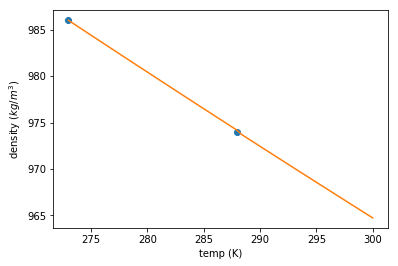

In [33]:
fig, ax = plt.subplots()
ax.plot(ref_t, ref_d, 'o')
ax.plot(temps, densities, '-')
ax.set_xlabel('temp (K)')
ax.set_ylabel('density ($kg/m^3$)')

**NOTE:** The slope looks pretty good, but there is a kink between the second and third points. I think that's because the code finds the nearest value, and then extrapolates using teh standard expansion coeff -- rather than interpolation between these values.

## trying the slope against oils with two density values.

In [35]:
# all the oils with two density values:
oils = [o for o in oils if len(o.densities) == 2]

# get all their densities with temps
oils[0].densities

def compute_exp_coeff(oil):
    """
    compute the exansion coeff for two known densities
    """
    d1 = oil.densities[0].kg_m_3
    t1 = oil.densities[0].ref_temp_k
    d2 = oil.densities[1].kg_m_3
    t2 = oil.densities[1].ref_temp_k

    # 1000 to convert to SG (close enough, anyway)
    exp_coeff = - (d2/1000 - d1/1000) / (t2-t1)
    return exp_coeff

coeffs = [compute_exp_coeff(oil) for oil in oils]
print (coeffs)
print ("mean:", np.average(coeffs))
print ("standard deviation:", np.std(coeffs))
print ("minimum:", np.min(coeffs))
print ("maximum:", np.max(coeffs))
print ("number of samples:", len(coeffs))

ZeroDivisionError: float division by zero

#### These are more or less in the same ballpark with one outlier - let's look at that one:

In [36]:

minimum = oils[1]
print (minimum.name)
print ("api:", minimum.api)
# meaasured densities
for d in minimum.densities:
    print (d)
print ("quality index:", minimum.quality_index)

ALASKA NORTH SLOPE
api: 26.8
<Density(904.0 kg/m^3 at 273.0K)>
<Density(893.87239418825 kg/m^3 at 288.15K)>
quality index: 0.5151515151515151


Nothing looks off here -- odd.